# Assignment 2: State prediction

In this assignment you are learning to estimate state from the acquired range-rate data.
You will capture the data and look at different arc settings and other estimation settings.

    - Propagation of initial orbit from TLE 
    - Setup your estimation: data selection, arc length, estimation parameters
    - Perform estimation
    - Inspect results
    - Validate your results
    - Reporting

Follow the text and code to perform the practical.

### UNITS and conventions
All parameters are represented in SI units or otherwise stated.

### Code usage
In this course you are using actual tracking data from the DopTrack laboratory (https://doptrack.tudelft.nl) and use the Delft-based orbit determination software Tudat (https://docs.tudat.space/en/stable/#) to perform orbit analysis.


In [1]:
# Load standard modules
import statistics
# Uncomment the following to make plots interactive
# %matplotlib widget
from matplotlib import pyplot as plt

# Import doptrack-estimate functions
from propagation_functions.environment import *
from propagation_functions.propagation import *
from estimation_functions.estimation import *
from estimation_functions.observations_data import *

from utility_functions.time import *
from utility_functions.tle import *
from utility_functions.data import extract_tar
from fit_sgp4_solution import fit_sgp4_solution

# Load tudatpy modules
from tudatpy.numerical_simulation import environment
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation_setup
from tudatpy.kernel.astro import element_conversion

In [2]:
# Extract data
extract_tar("./metadata.tar.xz")
extract_tar("./data.tar.xz")

# Define import folders
metadata_folder = 'metadata/'
data_folder = 'data/'

# Upload data

Lets upload Doppler data files and strat setting up the least square fitting. Put here your data files (.csv) and the metadata files (.yml) you want to use in the estimation. The meta files will be used to compute the initial orbit. Here, you can use the doptrack-data.tudelft.nl website to get processed data from the Delft DopTrack tracking station.

Go to the processed/tracking directory and select a satellite and year you want to use. Than, download the files you want to use for the assignment. Download data for one whole week.

We have made a default data set in data and metadata directories for the Delfi-C3 satellite, but you are more than welcome to use different data for the assignment (including your own satellite pass)

In [3]:
# Files to be uploaded
metadata = ['Delfi-C3_32789_202004011044.yml', 'Delfi-C3_32789_202004011219.yml',
            'Delfi-C3_32789_202004020904.yml', 'Delfi-C3_32789_202004021953.yml',
            'Delfi-C3_32789_202004031031.yml', 'Delfi-C3_32789_202004031947.yml',
            'Delfi-C3_32789_202004041200.yml',

            'Delfi-C3_32789_202004061012.yml', 'Delfi-C3_32789_202004062101.yml', 'Delfi-C3_32789_202004062236.yml',
            'Delfi-C3_32789_202004072055.yml', 'Delfi-C3_32789_202004072230.yml',
            'Delfi-C3_32789_202004081135.yml']

data = ['Delfi-C3_32789_202004011044.DOP1C', 'Delfi-C3_32789_202004011219.DOP1C',
        'Delfi-C3_32789_202004020904.DOP1C', 'Delfi-C3_32789_202004021953.DOP1C',
        'Delfi-C3_32789_202004031031.DOP1C', 'Delfi-C3_32789_202004031947.DOP1C',
        'Delfi-C3_32789_202004041200.DOP1C',

        'Delfi-C3_32789_202004061012.DOP1C', 'Delfi-C3_32789_202004062101.DOP1C', 'Delfi-C3_32789_202004062236.DOP1C',
        'Delfi-C3_32789_202004072055.DOP1C', 'Delfi-C3_32789_202004072230.DOP1C',
        'Delfi-C3_32789_202004081135.DOP1C']
        
# Specify which metadata and data files should be loaded (this will change throughout the assignment)
# indices_files_to_load = [0, 1]
indices_files_to_load = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12]

# Setting up a initial orbit propagation

For the least square estimator, a first initial guess needs to be performed. Especially for low-quality data and bad geometry, this initial guess should be close to the actual orbit to have the estimation converge. For this, we use the TLE data as this is already something we have and know is close to the actual orbit of the satellite. In Assignment 3, you are going to look at the effect of the error on the initial guess and how it effects the estimation.

For now, try to set the propagation time large enough that it compasses your complete dataset. This can be done by setting the parameter propagation_time to a number of days that you want to propagate the initial orbit.

In [4]:
# Retrieve initial epoch from TLE
initial_epoch, initial_state_teme, b_star = get_tle_initial_conditions(metadata_folder + metadata[0], old_yml=True)

# Define the propagation time, and compute the final and mid-propagation epochs accordingly.
propagation_time = 10.0 * constants.JULIAN_DAY
final_epoch = get_start_next_day(initial_epoch) + propagation_time
mid_epoch = (initial_epoch + final_epoch) / 2.0

# Retrieve the spacecraft's initial state at mid-epoch from the TLE orbit
initial_state = propagate_sgp4(metadata_folder + metadata[0], initial_epoch, [mid_epoch], old_yml=True)[0, 1:]

# Retrieve recording starting times
recording_start_times = extract_recording_start_times_yml(metadata_folder, [metadata[i] for i in indices_files_to_load], old_yml=True)

# Load and process observations
passes_start_times, passes_end_times, observation_times, observations_set = load_and_format_observations(
    "Delfi", data_folder, [data[i] for i in indices_files_to_load], recording_start_times, old_obs_format=True)

# Setting your estimation arcs

Here, you need to specify what type of arcs the data is cut into. So, are you calculating a new state after every pass, every day, 3 days or even a week. Here, a trade-off needs to make between the amount of collected data and the unmodelled disturbance forces during the arc. 

In the assignment, you are going to play with this setting to see what effect it has on the estimation.

In [5]:
# Define tracking arcs and retrieve the corresponding arc starting times (this will change throughout the assignment)
# Four options: one arc per pass ('per_pass'), one arc per day ('per_day'), one arc every 3 days ('per_3_days') and one arc per week ('per_week')
arc_start_times, arc_mid_times, arc_end_times = define_arcs('per_day', passes_start_times, passes_end_times)

print('arc_start_times', arc_start_times)
print('arc_end_times', arc_end_times)

arc_start_times [638971200.0, 639057600.0, 639144000.0, 639230400.0, 639403200.0, 639489600.0, 639576000.0]
arc_end_times [639057600.0, 639144000.0, 639230400.0, 639316800.0, 639489600.0, 639576000.0, 639662400.0]


# Setting the estimation settings

Now your initial guess is generated and you selected the estimation arcs, lets take a look at the environment of the satellite (forces acting on the s/c)

In [6]:
# Define propagation_functions environment
mass = 2.2
ref_area = (4 * 0.3 * 0.1 + 2 * 0.1 * 0.1) / 4  # Average projection area of a 3U CubeSat
srp_coef = 1.2
drag_coef = 1.2
bodies = define_environment(mass, ref_area, drag_coef, srp_coef, "Delfi", multi_arc_ephemeris=False)

# Define accelerations exerted on Delfi
# Warning: point_mass_gravity and spherical_harmonic_gravity accelerations should not be defined simultaneously for a single body
accelerations = dict(
    Sun={
        'point_mass_gravity': True,
        'solar_radiation_pressure': True
    },
    Moon={
        'point_mass_gravity': True
    },
    Earth={
        'point_mass_gravity': False,
        'spherical_harmonic_gravity': True,
        'drag': True
    },
    Venus={
        'point_mass_gravity': True
    },
    Mars={
        'point_mass_gravity': True
    },
    Jupiter={
        'point_mass_gravity': True
    }
)

# Propagate dynamics and retrieve Delfi's initial state at the start of each arc
orbit = propagate_initial_state(initial_state, initial_epoch, final_epoch, bodies, accelerations, "Delfi")
arc_wise_initial_states = get_initial_states(bodies, arc_mid_times, "Delfi")

In [7]:
# Redefine environment to allow for multi-arc dynamics propagation_functions
bodies = define_environment(mass, ref_area, drag_coef, srp_coef, "Delfi", multi_arc_ephemeris=True)

# Define multi-arc propagator settings
multi_arc_propagator_settings = define_multi_arc_propagation_settings(arc_wise_initial_states, arc_start_times, arc_end_times,
                                                                      bodies, accelerations, "Delfi")
# Create the DopTrack station
define_doptrack_station(bodies)

# Define default observation settings
# Specify on which time interval the observation bias(es) should be defined. This will change throughout the assignment (can be 'per_pass', 'per_arc', 'global')
# Noting that the arc duration can vary (see arc definition)
bias_definition = 'per_pass'
Doppler_models = dict(
    absolute_bias={
        'activated': True,
        'time_interval': bias_definition
    },
    relative_bias={
        'activated': True,
        'time_interval': bias_definition
    },
    time_drift={
        'activated': True,
        'time_interval': bias_definition
    }
)
observation_settings = define_observation_settings("Delfi", Doppler_models, passes_start_times, arc_start_times)

# Define parameters to estimate
parameters_list = dict(
    initial_state={
        'estimate': True
    },
    absolute_bias={
        'estimate': True
    },
    relative_bias={
        'estimate': False
    },
    time_drift={
        'estimate': True
    }
)
parameters_to_estimate = define_parameters(parameters_list, bodies, multi_arc_propagator_settings, "Delfi",
                                           arc_start_times, arc_mid_times, [(get_link_ends_id("DopTrackStation", "Delfi"), passes_start_times)], Doppler_models)
estimation_setup.print_parameter_names(parameters_to_estimate)

# Create the estimator object
estimator = numerical_simulation.Estimator(bodies, parameters_to_estimate, observation_settings, multi_arc_propagator_settings)

# Simulate (ideal) observations
ideal_observations = simulate_observations_from_estimator("Delfi", observation_times, estimator, bodies)

Parameter start index, Parameter definition
0, arc-wise translational state of (Delfi).
42, absolute arc-wise observation bias for observable: (OneWayDoppler) and link ends: (transmitter: (Delfi); receiver: (Earth, DopTrackStation))
54, arc-wise time drift observation bias for observable: (OneWayDoppler) and link ends: (transmitter: (Delfi); receiver: (Earth, DopTrackStation))



# Run the estimation

Now you are all setup to run the estimation. In the following block the dynamic equations are set and the estimator knows what kind of parameters need to be estimated.

Press run. This can take a while, depending on your amount of data and settings

In [8]:
# Save the true parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector
nb_parameters = len(truth_parameters)

# Perform estimation_functions
nb_iterations = 10
nb_arcs = len(arc_start_times)
pod_output = run_estimation(estimator, parameters_to_estimate, observations_set, nb_arcs, nb_iterations)

errors = pod_output.formal_errors
residuals = pod_output.residual_history
mean_residuals = statistics.mean(residuals[:,nb_iterations-1])
std_residuals = statistics.stdev(residuals[:,nb_iterations-1])

residuals_per_pass = get_residuals_per_pass(observation_times, residuals, passes_start_times)

print('--------------------------------------------------------------')
for i in range(len(residuals_per_pass)):
    print('size residuals current pass', np.shape(residuals_per_pass[i]))  


Calculating residuals and partials 11949
Current residual: 234.11
Parameter update -15133.4  -17030.8   13901.5   -6.3548   8.06779   5.11083  -9417.95  -5967.23   -6426.9    6.8891  -5.35634  -2.34161   6552.49  -5920.51  -6542.39   4.60709  -2.53856   10.1933   1672.88  -5181.28   14489.3  -1.25095   16.7749    4.3091    -22419  -7273.07   10344.5    18.189   59.7005 0.0386754  -6122.37  -12221.8   24573.9  -8.38611   32.3821   7.09463   16812.4   16670.6   10493.3  -10.3218   14.9723  0.810792   406.015   323.369   226.229   82.3935    448.66   395.861    369.84   378.033   539.095   294.231    189.22   514.181  -1.27426  -1.14155 -0.744217 -0.854066  -1.34785  -1.31005  -1.07325  -1.18115  -2.08766  -1.53678 -0.740821   -1.4085
Calculating residuals and partials 11949
Current residual: 32.4781
Parameter update   -5022.08    -3223.79    -1407.78     1.27197    -1.73347    -1.88097    -1264.83    -2305.72    -1515.75    0.606519  -0.0115718   -0.525679     5979.56    -5959.09       -

# Inspect the results

The first number that we look at is final residual. This shows the difference (root mean square) between the observed range-rate and the final orbit model estimated by your program.

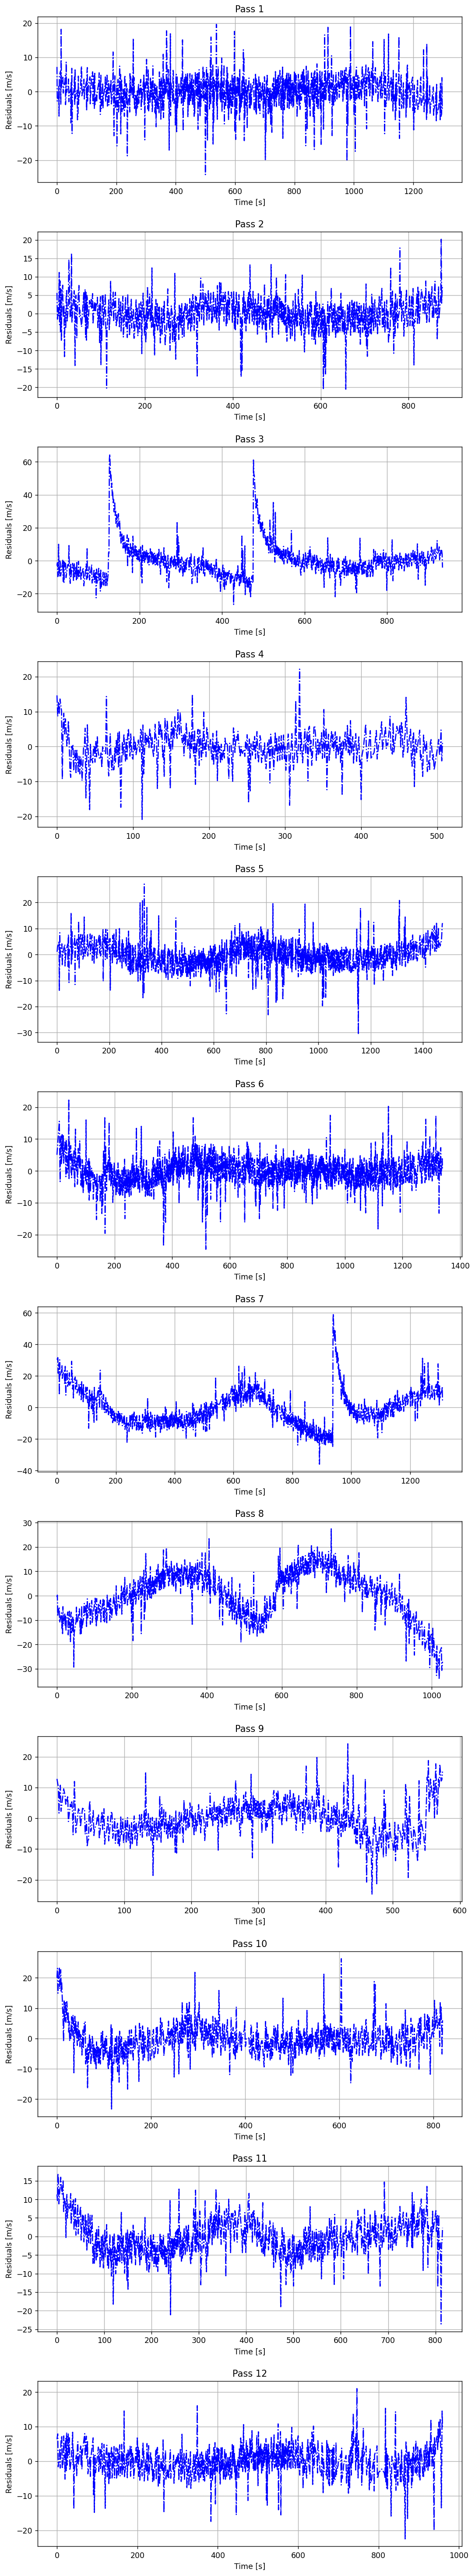

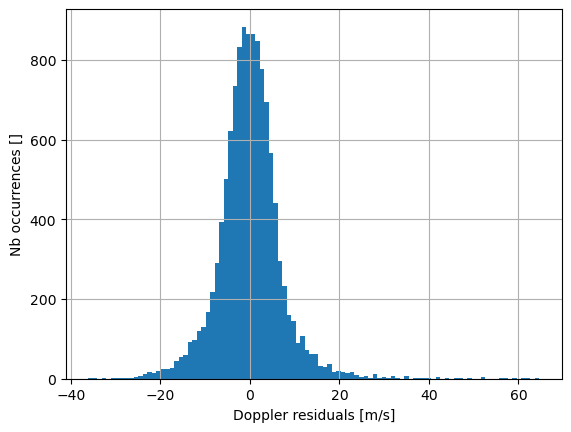

In [9]:
# Plot residuals

number_of_passes = len(indices_files_to_load)

fig = plt.figure(figsize=(10,number_of_passes*5.0), dpi=125)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

for i in range(len(passes_start_times)):
    ax = fig.add_subplot(len(passes_start_times), 1, i+1)
    ax.plot(residuals_per_pass[i], color='blue', linestyle='-.')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Residuals [m/s]')
    ax.set_title(f'Pass '+str(i+1))
    plt.grid()
plt.show()

# Plot residuals histogram
fig = plt.figure()
ax = fig.add_subplot()
# plt.hist(residuals[:,1],100)
plt.hist(residuals[:,nb_iterations-1],100)
ax.set_xlabel('Doppler residuals [m/s]')
ax.set_ylabel('Nb occurrences []')
plt.grid()
plt.show()



# Reporting

So, above you have a tool to estimate orbits from range-rate data. As, you have seen there are a lot of parameters to play with. Also, some of the observations are not of high quality. You will play around with the settings and deselecting observations to improve the orbit etsimation. For now, improving the orbit estimation is to reduce the final residual.

Please document the Final Residual and inspect the residual plots

### Settings: deactivate parameters, arc length, dynamical model

We first going to play with the **estimated biases**. We assumed in assignment 1 that the linear frequency drift was due to an onboard clock or voltage drift. But, could it also be an orbit feature. We can test this by deactivating the bias estimation (set to False)

Please document the Final Residual and inspect the residual plots

A second setting to play with is the **arc length**. This setting tells the estimator how much data is used per state estimation. So, `per_pass` means that every pass a state (an orbit solution) is estimated. Setting the arc length to `per_day` will generate orbits per day, using all data during the day. We have also included `per_week`, but for now this does not work properly yet, but that could change in assignment 3. Can you play with this setting and report on the results.

- Final residual when arc length is set to `per_pass`
- Final residual when arc length is set to `per_day`
- Final residual when arc length is set to `per_3_days`

You can also do this with the bias parameters, but because we strongly think that they are satellite related, we keep them on `per_pass`. However, in Assignment 3 your could play with those settings as well for certain dynamic model parameters.

In this assignment you are using the 'best' **dynamical model**. Try to find out what happens with the orbit estimation if you remove certain information from the dynamical model. Use per_pass arc length and estimate all biases. Then:

- Keep rest fixed, but turn off Earth drag
- Keep rest fixed, but now turn off solar radiation
- Keep rest fixed, but us a point mass model for Earth

Document in these scenarios what happens with the residual. Discuss why it is worse or better.

### Deselecting data 

Up until now we used all avaliable passes for input data. But we saw in the residuals filter that some passes show artifacts, glitches in the radio signal, start-up issues, or other measuring noise. We could deselect certain passes to improve our residuals? Would that also improve our orbit estimation? Deselect certain passes by altering `indices_files_to_load`

- use all 12 passes
- remove 'bad' passes according to you
- find 'best' pass

Run the estimation again with perfect settings. Document your choices of deselecting certain passes and report on the resulting residuals and orbits. What is the difference in residuals between all data orbits or the best pass orbit? And what about the intermediate orbit determination? Are these better orbits? How do you know? 

Here, you see that orbit determination is a trade-off between amount of data used and good residual, it is up to the modeller to choice the optimum. Validation of the orbit result play a huge role in this.



Student name:
    
Student number:
    
Discussion:

In [10]:
# some comparison suggestions that can help your orbit validation

updated_parameters = parameters_to_estimate.parameter_vector
print('----------------------------------------')
print('INITIAL STATE from TLE')
print(initial_state)
print('----------------------------------------')
print('UPDATED STATE ARC #1 from DOPTRACK')
print(updated_parameters[0:6])
print('----------------------------------------')
print('ALL ESTIMATED PARAMETERS')
print(updated_parameters)
gravitational_parameter = bodies.get("Earth").gravity_field_model.gravitational_parameter
state_keplerian = element_conversion.cartesian_to_keplerian(updated_parameters[0:6], gravitational_parameter)

print('-------------ARC #1 state---------------')
print('Semi-major axis = \t\t\t',state_keplerian[0]/1000, '\t km')
print('Eccentricity = \t\t\t\t',state_keplerian[1])
print('Inclination = \t\t\t\t',np.rad2deg(state_keplerian[2]), '\t deg')
print('Argument of Perigee = \t\t\t',np.rad2deg(state_keplerian[3]), '\t deg')
print('Right Ascension of Ascending Node = \t',np.rad2deg(state_keplerian[4]), '\t deg')
print('True anomaly = \t\t\t\t',np.rad2deg(state_keplerian[5]), '\t deg')
print('True longitude = \t\t\t',np.mod(np.rad2deg(state_keplerian[5])+np.rad2deg(state_keplerian[3]),360), '\t deg')
print('-------------ARC #1 state---------------')
print('Altitude = \t\t\t\t',state_keplerian[0]/1000-6371.360, '\t km')

TLE_keplerian = element_conversion.cartesian_to_keplerian(arc_wise_initial_states[0], gravitational_parameter)

print('---------------TLE state----------------')
print('Semi-major axis = \t\t\t',TLE_keplerian[0]/1000, '\t km')
print('Eccentricity = \t\t\t\t',TLE_keplerian[1])
print('Inclination = \t\t\t\t',np.rad2deg(TLE_keplerian[2]), '\t deg')
print('Argument of Perigee = \t\t\t',np.rad2deg(TLE_keplerian[3]), '\t deg')
print('Right Ascension of Ascending Node = \t',np.rad2deg(TLE_keplerian[4]), '\t deg')
print('True anomaly = \t\t\t\t',np.rad2deg(TLE_keplerian[5]), '\t deg')
print('True longitude = \t\t\t',np.mod(np.rad2deg(TLE_keplerian[5])+np.rad2deg(TLE_keplerian[3]),360), '\t deg')
print('---------------TLE state----------------')
print('Altitude = \t\t\t\t',TLE_keplerian[0]/1000-6371.360, '\t km')

# Manually coded for 7 daily arcs
pos_error1 = np.sqrt((updated_parameters[0]-arc_wise_initial_states[0][0])**2+(updated_parameters[1]-arc_wise_initial_states[0][1])**2+(updated_parameters[2]-arc_wise_initial_states[0][2])**2)
pos_error2 = np.sqrt((updated_parameters[6]-arc_wise_initial_states[1][0])**2+(updated_parameters[7]-arc_wise_initial_states[1][1])**2+(updated_parameters[8]-arc_wise_initial_states[1][2])**2)
pos_error3 = np.sqrt((updated_parameters[12]-arc_wise_initial_states[2][0])**2+(updated_parameters[13]-arc_wise_initial_states[2][1])**2+(updated_parameters[14]-arc_wise_initial_states[2][2])**2)
pos_error4 = np.sqrt((updated_parameters[18]-arc_wise_initial_states[3][0])**2+(updated_parameters[19]-arc_wise_initial_states[3][1])**2+(updated_parameters[20]-arc_wise_initial_states[3][2])**2)
pos_error5 = np.sqrt((updated_parameters[24]-arc_wise_initial_states[4][0])**2+(updated_parameters[25]-arc_wise_initial_states[4][1])**2+(updated_parameters[26]-arc_wise_initial_states[4][2])**2)
pos_error6 = np.sqrt((updated_parameters[30]-arc_wise_initial_states[5][0])**2+(updated_parameters[31]-arc_wise_initial_states[5][1])**2+(updated_parameters[32]-arc_wise_initial_states[5][2])**2)
pos_error7 = np.sqrt((updated_parameters[36]-arc_wise_initial_states[6][0])**2+(updated_parameters[37]-arc_wise_initial_states[6][1])**2+(updated_parameters[38]-arc_wise_initial_states[6][2])**2)
print('----------------------------------------')
print('Distance between TLE initial state and estimated state (ARC #1): ', pos_error1/1000)
print('IF AVAILABLE: Other ARC DISTANCE estimates')
print(pos_error2/1000)
print(pos_error3/1000)
print(pos_error4/1000)
print(pos_error5/1000)
print(pos_error6/1000)
print(pos_error7/1000)
print('----------------------------------------')
print('BIASES ESTIMATES')
print('ABSOLUTE BIASES ESTIMATES')
print(updated_parameters[42:54])
print('TIME DRIFT ESTIMATES')
print(updated_parameters[54:66])
#print(updated_parameters[66:78])





----------------------------------------
INITIAL STATE from TLE
[-1.21771033e+06  2.08317337e+06  6.48575774e+06  5.78008102e+03
 -4.26102772e+03  2.44185403e+03]
----------------------------------------
UPDATED STATE ARC #1 from DOPTRACK
[ 3.07140692e+06 -1.77750062e+06  5.94390182e+06  4.51884248e+03
 -4.77847952e+03 -3.77341726e+03]
----------------------------------------
ALL ESTIMATED PARAMETERS
[ 3.07140692e+06 -1.77750062e+06  5.94390182e+06  4.51884248e+03
 -4.77847952e+03 -3.77341726e+03  4.53516289e+06 -3.29512001e+06
  4.03439210e+06  2.84477817e+03 -3.56478061e+03 -6.08473229e+03
  5.31691815e+06 -4.26677564e+06  1.44384808e+06  6.36918870e+02
 -1.79889724e+03 -7.29195544e+03  5.13481226e+06 -4.44889732e+06
 -1.34405076e+06 -1.77877282e+03  2.16161028e+02 -7.37030268e+03
  2.34832103e+06 -2.80411773e+06 -5.86179870e+06 -5.43345826e+03
  3.61398898e+03 -3.89247209e+03  1.59366169e+05 -1.25838185e+06
 -6.78835421e+06 -6.12775339e+03  4.39490619e+03 -9.44321227e+02
 -2.0935741

In [11]:
# comparing orbits
bodies = define_environment(mass, ref_area, drag_coef, srp_coef, "Delfi",multi_arc_ephemeris=False)

# Define accelerations exerted on Delfi
# Warning: point_mass_gravity and spherical_harmonic_gravity accelerations should not be defined simultaneously for a single body
accelerations = dict(
    Sun={
        'point_mass_gravity': True,
        'solar_radiation_pressure': True
    },
    Moon={
        'point_mass_gravity': True
    },
    Earth={
        'point_mass_gravity': False,
        'spherical_harmonic_gravity': True,
        'drag': True
    },
    Venus={
        'point_mass_gravity': True
    },
    Mars={
        'point_mass_gravity': True
    },
    Jupiter={
        'point_mass_gravity': True
    }
)

estimated_state = updated_parameters[0:6]
TLE_state = arc_wise_initial_states[0]

#estimated_orbit = propagate_initial_state(estimated_state, arc_start_times[0]+3600, arc_mid_times[0]-3600, bodies, accelerations)
#TLE_orbit = propagate_initial_state(TLE_state, arc_start_times[0]+3600, arc_mid_times[0]-3600, bodies, accelerations)

estimated_orbit = propagate_initial_state(estimated_state, arc_start_times[0], arc_end_times[0], bodies, accelerations, "Delfi")
TLE_orbit = propagate_initial_state(TLE_state, arc_start_times[0], arc_end_times[0], bodies, accelerations, "Delfi")

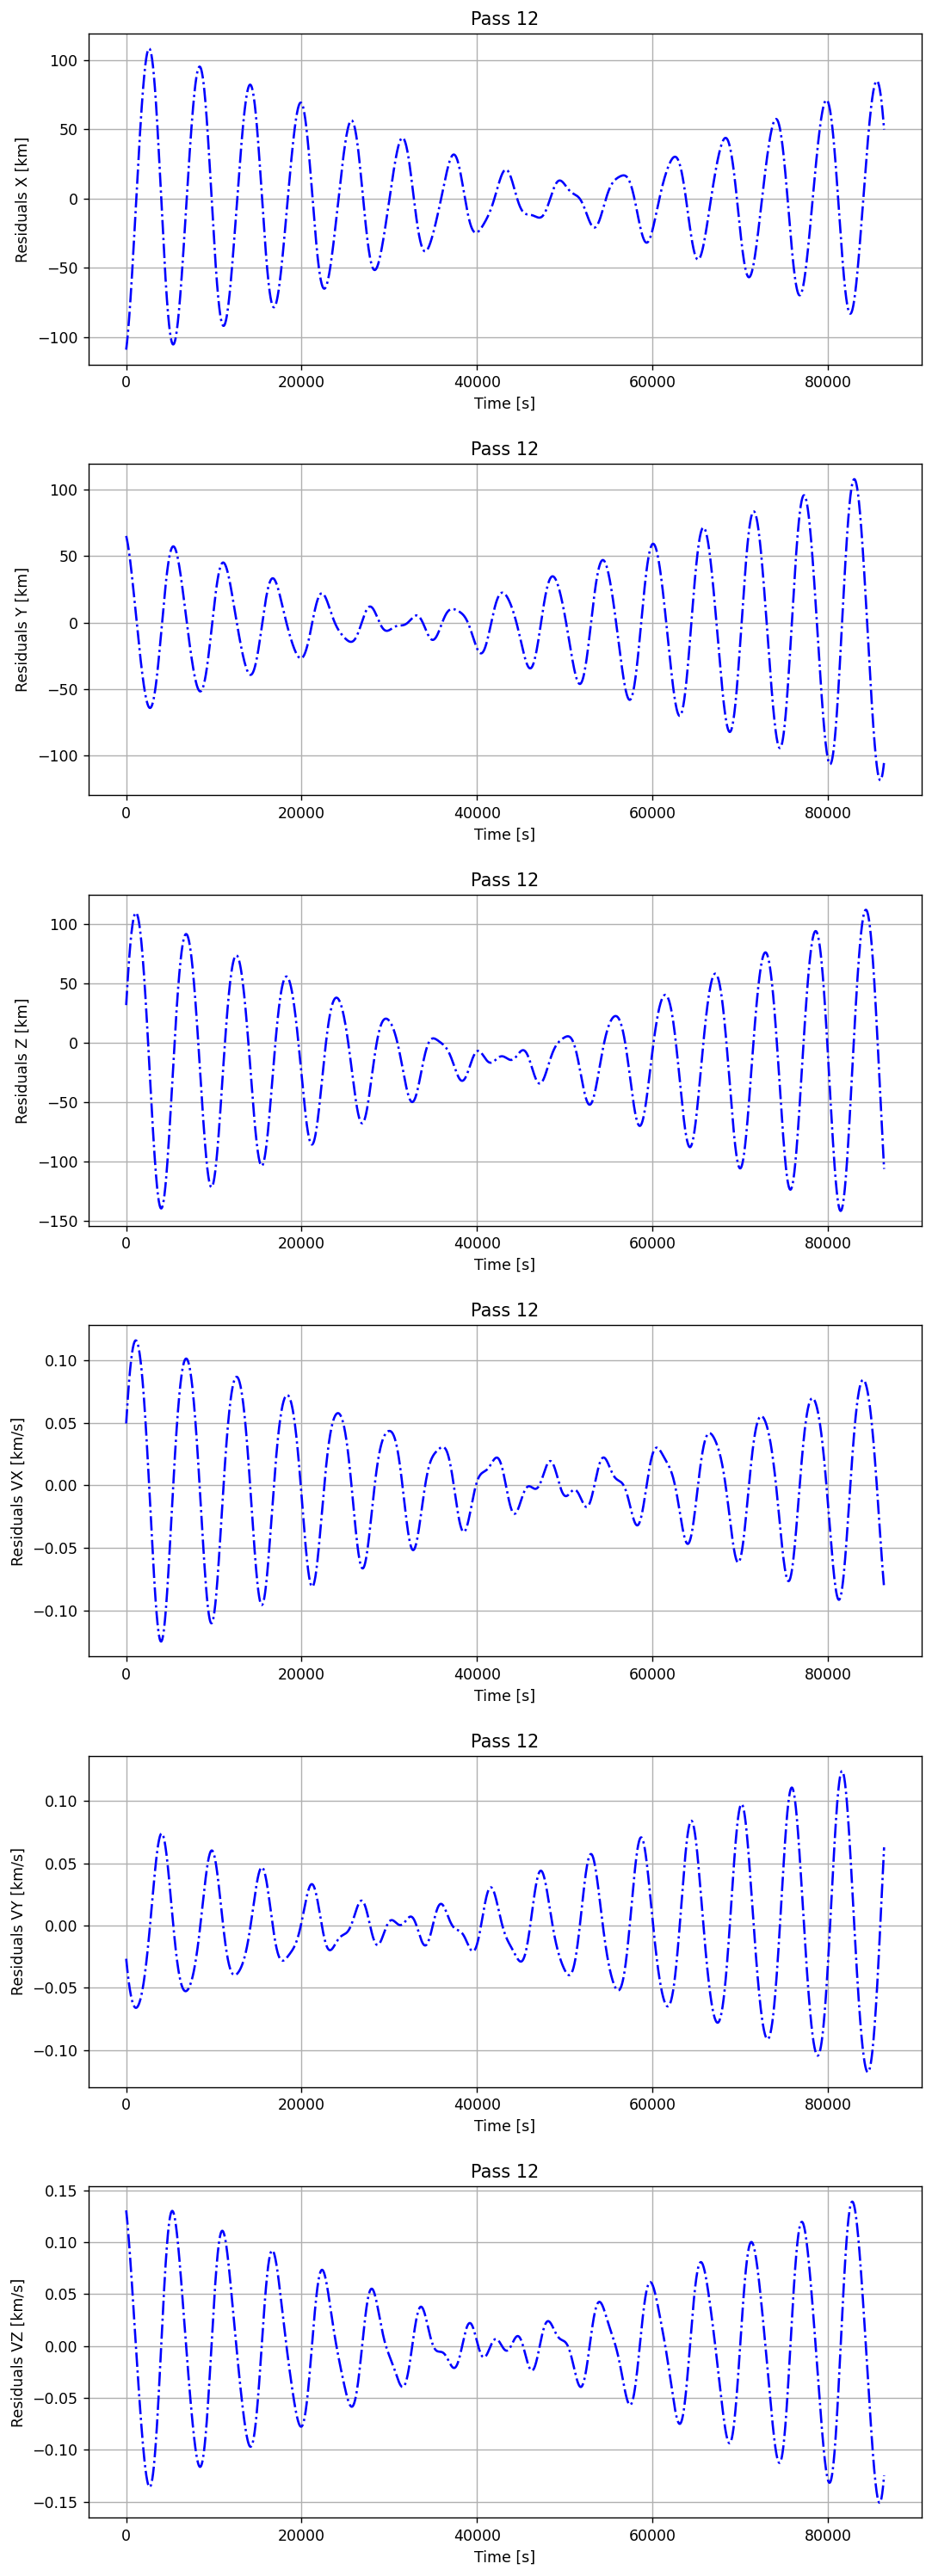

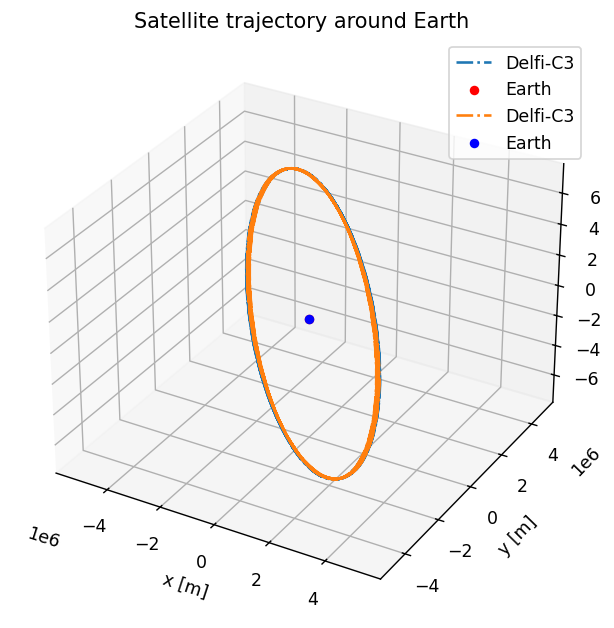

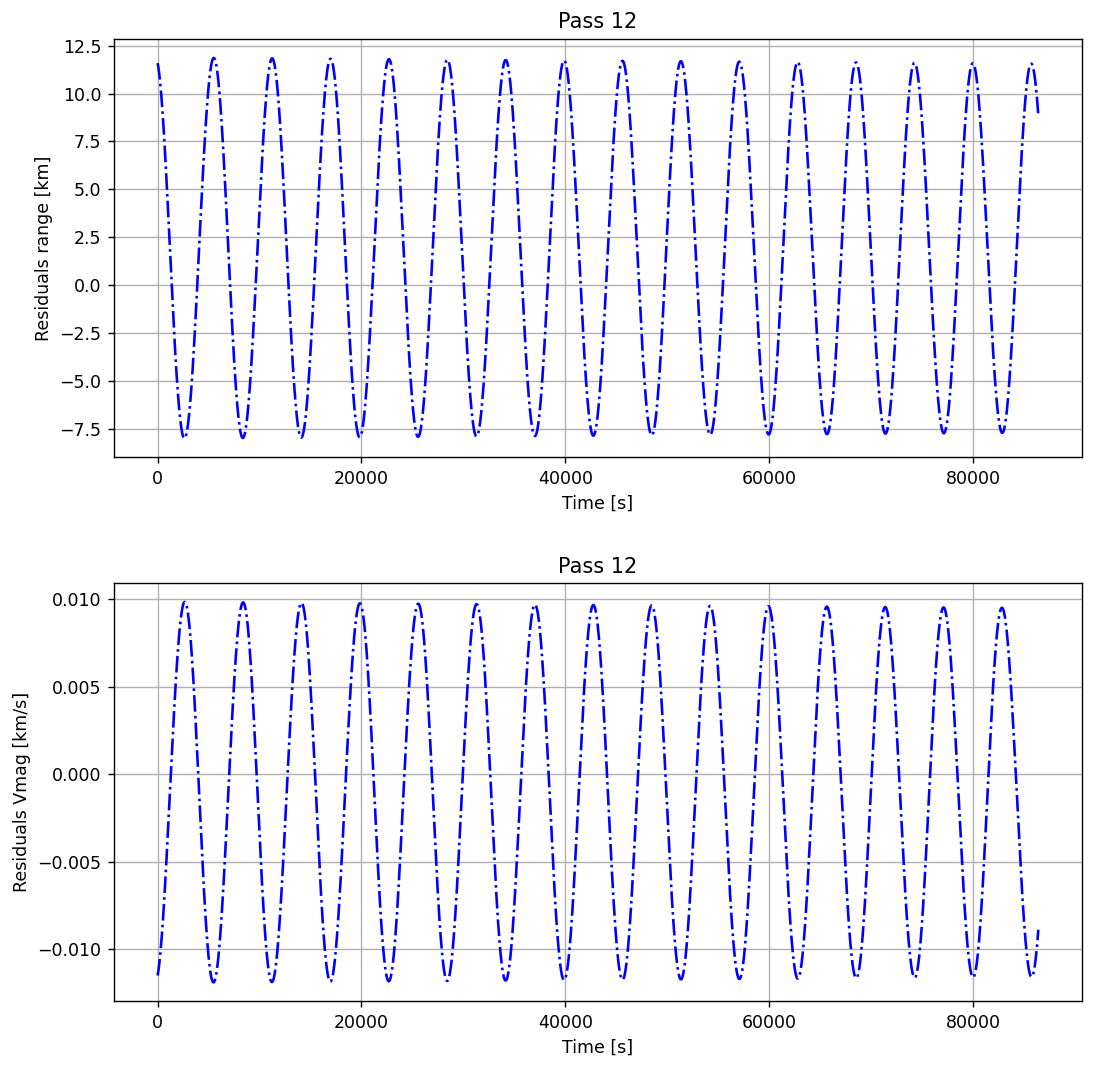

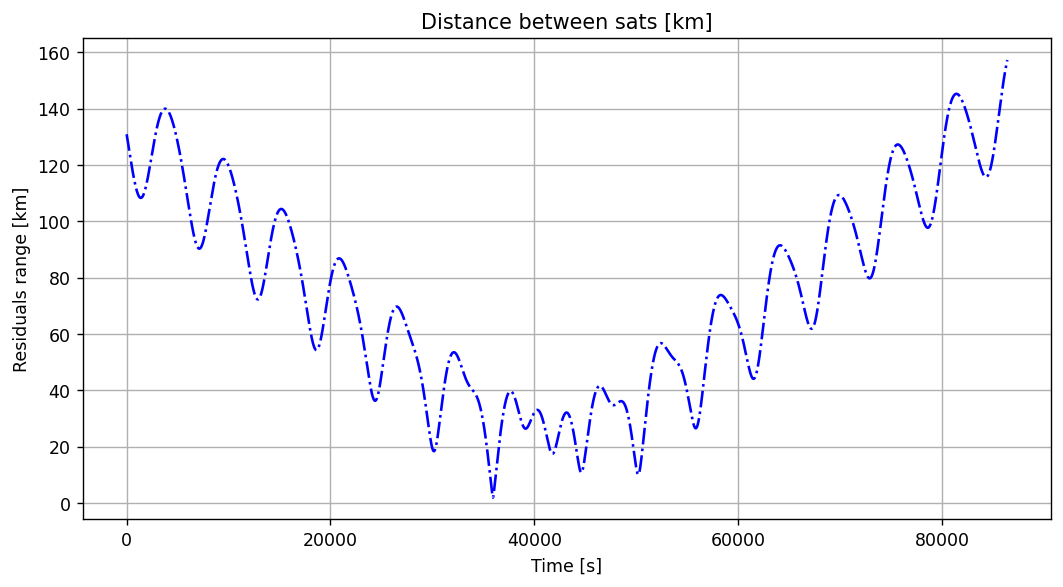

In [12]:
# Some suggestions to plot differences between TLE orbit and estimated orbit.

fig = plt.figure(figsize=(10,6*5.0), dpi=125)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)
ax = fig.add_subplot(6, 1, 1)
ax.plot(TLE_orbit[0][:,0]-TLE_orbit[0][0,0],(TLE_orbit[0][:,1]-estimated_orbit[0][:,1])/1000, color='blue', linestyle='-.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residuals X [km]')
ax.set_title(f'Pass '+str(i+1))
plt.grid()

ax = fig.add_subplot(6, 1, 2)
ax.plot(TLE_orbit[0][:,0]-TLE_orbit[0][0,0],(TLE_orbit[0][:,2]-estimated_orbit[0][:,2])/1000, color='blue', linestyle='-.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residuals Y [km]')
ax.set_title(f'Pass '+str(i+1))
plt.grid()

ax = fig.add_subplot(6, 1, 3)
ax.plot(TLE_orbit[0][:,0]-TLE_orbit[0][0,0],(TLE_orbit[0][:,3]-estimated_orbit[0][:,3])/1000, color='blue', linestyle='-.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residuals Z [km]')
ax.set_title(f'Pass '+str(i+1))
plt.grid()

ax = fig.add_subplot(6, 1, 4)
ax.plot(TLE_orbit[0][:,0]-TLE_orbit[0][0,0],(TLE_orbit[0][:,4]-estimated_orbit[0][:,4])/1000, color='blue', linestyle='-.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residuals VX [km/s]')
ax.set_title(f'Pass '+str(i+1))
plt.grid()

ax = fig.add_subplot(6, 1, 5)
ax.plot(TLE_orbit[0][:,0]-TLE_orbit[0][0,0],(TLE_orbit[0][:,5]-estimated_orbit[0][:,5])/1000, color='blue', linestyle='-.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residuals VY [km/s]')
ax.set_title(f'Pass '+str(i+1))
plt.grid()

ax = fig.add_subplot(6, 1, 6)
ax.plot(TLE_orbit[0][:,0]-TLE_orbit[0][0,0],(TLE_orbit[0][:,6]-estimated_orbit[0][:,6])/1000, color='blue', linestyle='-.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residuals VZ [km/s]')
ax.set_title(f'Pass '+str(i+1))
plt.grid()
plt.show()


# Plot propagated orbit
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f'Satellite trajectory around Earth')
ax.plot(TLE_orbit[0][:, 1], TLE_orbit[0][:, 2], TLE_orbit[0][:, 3], label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='red')
ax.plot(estimated_orbit[0][:, 1], estimated_orbit[0][:, 2], estimated_orbit[0][:, 3], label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()

range_TLE = np.sqrt(TLE_orbit[0][:,1]**2+TLE_orbit[0][:,2]**2+TLE_orbit[0][:,3]**2)
range_estimated = np.sqrt(estimated_orbit[0][:,1]**2+estimated_orbit[0][:,2]**2+estimated_orbit[0][:,3]**2)

Vmag_TLE = np.sqrt(TLE_orbit[0][:,4]**2+TLE_orbit[0][:,5]**2+TLE_orbit[0][:,6]**2)
Vmag_estimated = np.sqrt(estimated_orbit[0][:,4]**2+estimated_orbit[0][:,5]**2+estimated_orbit[0][:,6]**2)

fig = plt.figure(figsize=(10,2*5.0), dpi=125)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)
ax = fig.add_subplot(2, 1, 1)
ax.plot(TLE_orbit[0][:,0]-TLE_orbit[0][0,0],(range_TLE-range_estimated)/1000, color='blue', linestyle='-.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residuals range [km]')
ax.set_title(f'Pass '+str(i+1))
plt.grid()

ax = fig.add_subplot(2, 1, 2)
ax.plot(TLE_orbit[0][:,0]-TLE_orbit[0][0,0],(Vmag_TLE-Vmag_estimated)/1000, color='blue', linestyle='-.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residuals Vmag [km/s]')
ax.set_title(f'Pass '+str(i+1))
plt.grid()


position = np.sqrt((TLE_orbit[0][:,1]-estimated_orbit[0][:,1])**2+(TLE_orbit[0][:,2]-estimated_orbit[0][:,2])**2+(TLE_orbit[0][:,3]-estimated_orbit[0][:,3])**2)

fig = plt.figure(figsize=(10,1*5.0), dpi=125)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TLE_orbit[0][:,0]-TLE_orbit[0][0,0],(position)/1000, color='blue', linestyle='-.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Residuals range [km]')
ax.set_title('Distance between sats [km]')
plt.grid()